# Pembelajaran Mesin: Tugas Besar 2

Kaenova Mahendra Auditama (1301190324)  
M Adi Ikfini (1301194160)  
IF-43-02  

  
Pada kodingan ini, kami mencoba untuk membuat sebuah model yang akan digunakan untuk membuat prediksi pada suatu data. Data yang diberikan merupakan data ketertarikan pelanggan untuk membeli kendaraan baru. Kami diminta untuk menggunakan metode supervised learning untuk melakukan prediksi tersebut. Kami akan mencoba melakukan prediksi menggunakan training data dan testing data dengan data yang imbalance.
  
  
<sup>\*runs on AI Lab computer</sup>

# Import Library

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle
import random
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from urllib.request import urlopen

# Import Data

## Import Train

In [2]:
df_raw_train = pd.read_csv("../data/raw/kendaraan_train.csv")
df_raw_train.head()

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0


In [3]:
len(df_raw_train)

285831

## Import Test

In [4]:
df_raw_test = pd.read_csv("../data/raw/kendaraan_test.csv")
df_raw_test.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,Wanita,49,1,8,0,1-2 Tahun,Pernah,46963,26,145,0
1,Pria,22,1,47,1,< 1 Tahun,Tidak,39624,152,241,0
2,Pria,24,1,28,1,< 1 Tahun,Tidak,110479,152,62,0
3,Pria,46,1,8,1,1-2 Tahun,Tidak,36266,124,34,0
4,Pria,35,1,23,0,1-2 Tahun,Pernah,26963,152,229,0


In [5]:
len(df_raw_test)

47639

# Data Exploration

## Check Imbalance on RAW Data (Before PreProcessing)

In [17]:
neg, pos = np.bincount(df_raw_train['Tertarik'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 285831
    Positive: 35006 (12.25% of total)



In [18]:
neg, pos = np.bincount(df_raw_test['Tertarik'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 47639
    Positive: 5861 (12.30% of total)



## Check Null Data

In [20]:
df_raw_train.isnull().values.any()

True

In [45]:
df_nan_raw_train = df_raw_train[df_raw_train.isnull().any(axis=1)]

In [47]:
neg, pos = np.bincount(df_nan_raw_train['Tertarik'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 114763
    Positive: 14208 (12.38% of total)



In [21]:
df_raw_test.isnull().values.any()

False

The train data has a null data with a terget category ratio similiar with the RAW data, thus if we try to delete the null data, the ratio is slightly change and didnt break the data itself. Other than that, the test data, doesn't have null data.

## Checking Outlier using Box Plot
Checking outlier on Umur and Lama_Berlangganan

Text(0.5, 1.0, 'Lama Berlangganan')

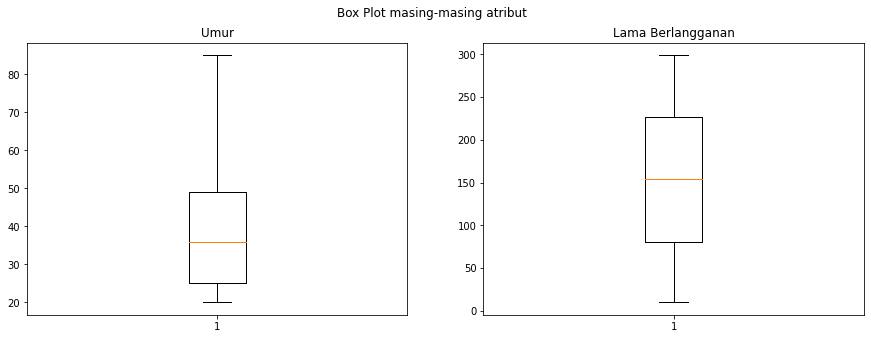

In [188]:
fig, (g1, g2) = plt.subplots(1,2)
fig.suptitle("Box Plot masing-masing atribut")
fig.set_size_inches(15,5)
g1.boxplot(df_raw_train.dropna(how="any")["Umur"])
g1.set_title("Umur")
g2.boxplot(df_raw_train.dropna(how="any")["Lama_Berlangganan"])
g2.set_title("Lama Berlangganan")

Nice.. tidak ada outlier walaupun dihilangkan NaN nya

## Analyzing Weird Attribute
*An attribute that doesn't have any explanation or we just can't figure it out (lol)

![](https://www.uth.tmc.edu/uth_orgs/educ_dev/oser/FIG1_1.GIF)

In [6]:
# Let's remove the NaN values in dataframe for better analyze 

df_train_analyze_all = df_raw_train.dropna(how="any") # If we remove any nan value in any columns

df_train_analyze_daerah = df_raw_train["Kode_Daerah"].dropna(how="any") # remove nan value in kode_daerah column
df_test_analyze_daerah = df_raw_test["Kode_Daerah"].dropna(how="any")

df_train_analyze_kanal = df_raw_train["Kanal_Penjualan"].dropna(how="any") # remove nan value in kanal_penjualan column
df_test_analyze_kanal = df_raw_test["Kanal_Penjualan"].dropna(how="any")

df_train_analyze_premi = df_raw_train["Premi"].dropna(how="any")

In [100]:
df_train_analyze_all.columns

Index(['id', 'Jenis_Kelamin', 'Umur', 'SIM', 'Kode_Daerah', 'Sudah_Asuransi',
       'Umur_Kendaraan', 'Kendaraan_Rusak', 'Premi', 'Kanal_Penjualan',
       'Lama_Berlangganan', 'Tertarik'],
      dtype='object')

In [101]:
categorical_cols = ['Jenis_Kelamin', 'SIM', 'Sudah_Asuransi', 'Kendaraan_Rusak', 'Tertarik']

In [20]:
df_train_analyze_all["Kendaraan_Rusak"].unique()

array(['Tidak', 'Pernah'], dtype=object)

In [23]:
map_bruh = {
    "Kendaraan_Rusak" : {
        "Tidak" : 0,
        "Pernah" : 1
    }
}
test = df_train_analyze_all.replace(map_bruh)

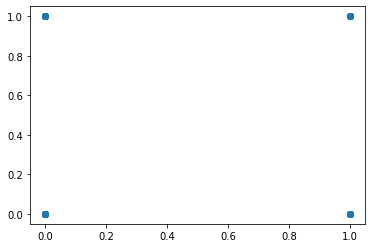

In [26]:
plt.scatter(test["Kendaraan_Rusak"], test["Sudah_Asuransi"])

### Kode Daerah
Dari namanya, bisa kita sebutkan bahwa ini sebuah qualitative (nominal) atribut(?).  
let's try to treat it as it is

(array([13907., 36260., 24514.,  9413.,  8844., 97287., 19907., 22614.,
        21052., 17727.]),
 array([ 0. ,  5.2, 10.4, 15.6, 20.8, 26. , 31.2, 36.4, 41.6, 46.8, 52. ]),
 <BarContainer object of 10 artists>)

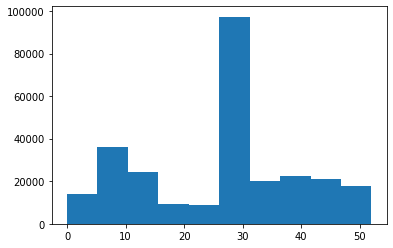

In [74]:
plt.hist(df_train_analyze_daerah)

(array([ 8766., 22877., 15401.,  5911.,  5615., 61164., 12612., 14237.,
        13283., 11202.]),
 array([ 0. ,  5.2, 10.4, 15.6, 20.8, 26. , 31.2, 36.4, 41.6, 46.8, 52. ]),
 <BarContainer object of 10 artists>)

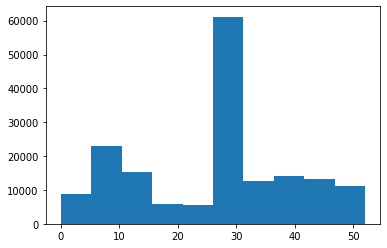

In [75]:
plt.hist(df_train_analyze_all["Kode_Daerah"])

(array([ 2412.,  6385.,  4379.,  1666.,  1558., 17125.,  3500.,  3945.,
         3632.,  3037.]),
 array([ 0. ,  5.2, 10.4, 15.6, 20.8, 26. , 31.2, 36.4, 41.6, 46.8, 52. ]),
 <BarContainer object of 10 artists>)

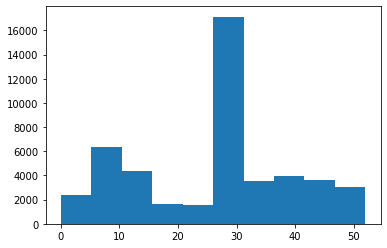

In [76]:
plt.hist(df_test_analyze_daerah)

In [77]:
np.sort(df_train_analyze_daerah.unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52.])

In [78]:
np.sort(df_train_analyze_all["Kode_Daerah"].unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52.])

Bisa diambil kesimpulan bahwa kita bisa menganggap atribut ini sebagai atribut Categorical, selain itu kita bisa melakukan One Hot Encoding terhadap atribut ini, dikarenakan distribusi dari atribnut ini serupa dan bisa di intuisikan bahwa setiap nilai memiliki "beratnya tersendiri." Hal ini kami bisa anggap aman karena pada data testing pun memiliki distribusi yang serupa walaupun pada setiap kolom jika ada nilai null dan dihapus.

### Premi
First of all, what the heck is Premi even means?  
In KBBI (https://kbbi.kemdikbud.go.id/entri/premi) we can conclude that premi is quantitative attribute(?)  
1. n hadiah (uang dan sebagainya) yang diberikan sebagai perangsang untuk meningkatkan prestasi kerja
2. n hadiah (dalam undian, perlombaan, pembelian)
3. n jumlah uang yang harus dibayarkan pada waktu tertentu kepada asuransi sosial: -- asuransi

  
With this, let's try to treat it as quantitative attribute

In [7]:
# Let's see if it's a float data or numerical data
np.unique(df_train_analyze_premi.unique() % 1)

array([0.])

Setelah dilihat, setiap nilai jika di modulus kan dengan nilai 1, semua hasil elemennya ialah 0. Sehingga bisa disimpulkan ini merupakan data numerical non floating (integer).

In [80]:
# Let's see the correlation between the any other variables
df_train_analyze_all.corr()["Premi"]

id                   0.002145
Umur                 0.063838
SIM                 -0.012864
Kode_Daerah         -0.012462
Sudah_Asuransi       0.003988
Premi                1.000000
Kanal_Penjualan     -0.112297
Lama_Berlangganan   -0.001260
Tertarik             0.021890
Name: Premi, dtype: float64

In [ ]:
# plt.scatter(df_train_analyze_all["Tertarik"], df_train_analyze_all["Premi"] )

Feels like it doesn't have any correlation with any other quantitative attribute

{'whiskers': [<matplotlib.lines.Line2D at 0x1d453ad7250>,
 'caps': [<matplotlib.lines.Line2D at 0x1d453ad7910>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d453afc1f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1d453afa400>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d453afabb0>],
 'means': []}

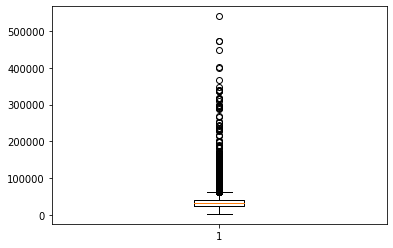

In [155]:
# Let's see how the premi looks like
plt.boxplot(df_train_analyze_all["Premi"])

In [116]:
df_train_analyze_premi.describe()

count    271262.000000
mean      30536.683472
std       17155.000770
min        2630.000000
25%       24398.000000
50%       31646.000000
75%       39377.750000
max      540165.000000
Name: Premi, dtype: float64

In [162]:
# Let's see if total data if we remove the outlier using inter-quartile range method
print("Total data:", len(df_train_analyze_all))
df_train_analyze_all_premi = df_train_analyze_all["Premi"]
print("Not Outliers data:", len(df_train_analyze_all_premi[(df_train_analyze_all_premi < df_train_analyze_all_premi.describe().loc["75%"]) \
                           & (df_train_analyze_all_premi > df_train_analyze_all_premi.describe().loc["25%"])]))

Total data: 171068
Not Outliers data: 85534


Wew berkurang 50%.  
Mungkin biar aman, kita tidak perlu memasukkan Premi sebagai fitur model.  
Mengapa?
1. Data tidak bisa dianalisa dengan baik
2. Nilai korelasi yang rendah dengan atribut-atribute lain.
3. Ketika melakukan handling outlier terlalu mengurangi jumlah data

FIX PREMI TIDAK USAH JADI FITUR - TDT Kaenova & Adi

### Kanal Penjualan
(synm.) Salur penjualan(?)  
  
Kalau dari kata-katanya tidak mungkin ini nilai quantitative, yang sangat memungkinkan ini merupakan qualitative dalam bentuk numerical dan tidak bersifat ordinal. Let's analyze it

In [168]:
# Let's see if it's a float data or numerical data
np.unique(df_train_analyze_kanal.unique() % 1)

array([0.])

Okay.. it's a numerical non floating number. This strengthen the theory that it's a qualitative attribute

In [169]:
np.sort(df_train_analyze_kanal.unique())

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  42.,  44.,  45.,  46.,  47.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
        59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
        70.,  71.,  73.,  74.,  75.,  76.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116.,
       117., 118., 119., 120., 121., 122., 123., 124., 125., 126., 127.,
       128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 138.,
       139., 140., 144., 145., 146., 147., 148., 150., 151., 152., 153.,
       154., 155., 156., 157., 158., 159., 160., 16

In [177]:
# Let's check what number that didn't appear in the array
kanal_unique = np.sort(df_train_analyze_kanal.unique())
for i in range(1, int(kanal_unique[len(kanal_unique) - 1])):
    if i not in kanal_unique:
        print(i, end=", ")

5, 41, 43, 72, 77, 85, 141, 142, 143, 149, 161, 162, 

In [181]:
len(np.sort(df_train_analyze_kanal.unique()))

151

In [182]:
len(np.sort(df_raw_train["Kanal_Penjualan"].unique())) - 1 # kurangin nilai nan

151

Ada beberapa nilai yang tidak terdapat dalam range data tersebut

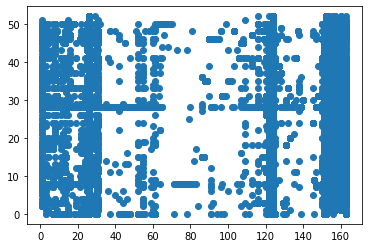

In [185]:
plt.scatter(df_train_analyze_all["Kanal_Penjualan"], df_train_analyze_all["Kode_Daerah"])

Ambil contoh 1 sample, Kanal Penjualan "160" ada pada semua daerah. Artinya Kanal Penjualan tidak bisa dihubungkan dengan daerahnya. Sehingga kanal penjualan tidak terpaku pada daerahnya maisng-masing.  

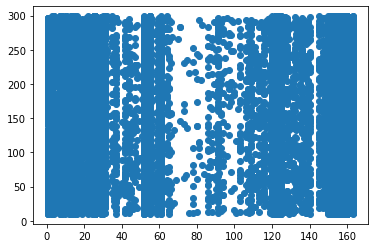

In [187]:
plt.scatter(df_train_analyze_all["Kanal_Penjualan"], df_train_analyze_all["Lama_Berlangganan"])

Disini kami bisa menyimpulkan bahwa ini merupakan atribut ini merupakan variable qualitative non ordinal.
1. Tidak ada nilai koma, nilai koma sangat jarang dipakai pada nilai qualitative ataupun atribut kategorikal.
2. Ada beberapa nilai yang tidak ada dalam range nilai tersebut, diantaranya [5, 41, 43, 72, 77, 85, 141, 142, 143, 149, 161, 162,] Hal ini sangat wajar dalam atribut kategorikal yang belum tentu angka numerik harus terisi semua dalam range nya.

# Data Preprocessing

Berdasarkan eksplorasi data yang kita temukan kami menyimpulkan beberapa poin:
1. Atribut yang tidak dijadikan fitur dalam model kami: [id, Premi, Tertarik]
2. Melakukan One Hot Encoding pada fitur categorical: ['Jenis_Kelamin', 'SIM', 'Sudah_Asuransi', 'Kendaraan_Rusak', 'Kanal_Penjualan']
3. Melakukan MinMaxScaler pada fitur numerical: ['Umur', 'Lama_Berlangganan']
4. Duplikat Data, Null Data
     
    
1. Kita buat 2 jenis data, pertama Kanal_Penjualan numerical, dan Kanal_Penjualan Categorical --> Insight data jenis apa sih Kanal Penjualan itu?
  
  
Jangan lupa preprocessing data testing

# Modelling

In [15]:
## Neural Network. -> Forward and Backward Propagation.
## Reggresion. -> 
## Decssion Tree. -> 
## Random Forest. -> 

# Eksperimen Utama